# Workshop 5: Introduction to Zarr and object store

In this workshop, we provide an introduction to working with data in object stores, using the Zarr Python package.

**The learning objectives are to:**
- provide basic understanding of the fundamental data structures in Zarr (Groups and Arrays)
- provide key properties of Arrays (shape, dtype, chunks, attributes)
- understand how to create Arrays and Groups in local files
- understand how to create and edit attributesmpressors




## Zarr
Zarr is a file storage format for chunked, compressed, N-dimensional arrays based on an open-source specification.

It has several key features:
- Create N-dimensional arrays with any NumPy dtype.
- 
Chunk arrays along any dimension- 

Compress and/or filter chunks using any NumCodecs cod- c.

Store arrays in memory, on disk, inside a Zip file, on - 3, …

Read an array concurrently from multiple threads or pro- esses.

Write to an array concurrently from multiple threads or p- ocesses.

Organize arrays into hierarchies via groups.


A Zarr array has the following properties: 
- Shape
- Dtype
- Attributes
- Filters/compressors

## Set up

In [1]:
import numpy as np
import os as os
from pprint import pprint as print
import s3fs
import zarr
import xarray as xr

## Zarr
### Creating an array
Create a 2-dimensional array of 32-bit integers with 10000 rows and 10000 columns, divided into chunks where each chunk has 1000 rows and 1000 columns (and so there will be 100 chunks in total).

In [2]:
z = zarr.zeros((10000, 10000), chunks=(1000, 1000), dtype='i4')
z

<zarr.core.Array (10000, 10000) int32>

See some diagnostic infromation about an array.

In [3]:
z.info

Type,zarr.core.Array
Data type,int32
Shape,"(10000, 10000)"
Chunk shape,"(1000, 1000)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,400000000 (381.5M)
No. bytes stored,345
Storage ratio,1159420.3


### Reading and writing data
Zarr arrays support a similar interface to NumPy arrays for reading and writing data. For example, the entire array can be filled with a scalar value or regions can be written.

In [4]:
z[:] =  7
z[0,:] = np.arange(10000)


The contents of the array can be retrieved by slicing, loading the regions into memory as a NumPy array.

In [5]:
print(z[0,0])
print(z[-1,-1])
print(z[0,:])
print(z[:,0])

0
7
array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int32)
array([0, 7, 7, ..., 7, 7, 7], dtype=int32)


### Persistent arrays
So far, compressed data for each chunk of the array was stored in main memory. Zarr arrays can also be stored on a file system, enabling persistence of data between sessions. 
Here the configuration metadata and all compressed chunk data in a directory called ‘data/example.zarr’ relative to the current working directory.
Note that although the function is called “open”, there is no need to close an array: data are automatically flushed to disk, and files are automatically closed whenever an array is modified.

In [6]:
z1 = zarr.open('data/example.zarr', mode='w', shape=(10000, 10000),
               chunks=(1000, 1000), dtype='i4')

Look for the file 

In [7]:
print("Current working directory is:")
print(os.getcwd()+"\n")

print("This directory contains the metadata and data:")
print(str(os.listdir('./data'))+"\n")


'Current working directory is:'
'/home/users/kitmac\n'
'This directory contains the metadata and data:'
"['example.zarr']\n"


Persistent arrays support the same interface for reading and writing data

In [8]:
z1[:] = 7
z1[0, :] = np.arange(10000)

Check that the data have been written and can be read again.

In [9]:
z2 = zarr.open('data/example.zarr', mode='r')
np.all(z1[:] == z2[:])

True

There are fast and convenient way to save NumPy arrays to disk and load back into memory.

In [10]:
a = np.arange(10)
zarr.save('data/example.zarr', a)
zarr.load('data/example.zarr')

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Resizing and appending
A Zarr array can be resized, which means that any of its dimensions can be increased or decreased in length. Note that when an array is resized, the underlying data are not rearranged in any way. If one or more dimensions are shrunk, any chunks falling outside the new array shape will be deleted from the underlying store.

In [11]:
z = zarr.zeros(shape=(10000, 10000), chunks=(1000, 1000))
z[:] = 42
z.resize(20000, 10000)
z.shape

(20000, 10000)

Zarr arrays also provide an `append()' method, which can be used to append data to any axis.

In [12]:
a = np.arange(10000000, dtype='i4').reshape(10000, 1000)
z = zarr.array(a, chunks=(1000, 100))
print(z.shape)
z.append(a)
print(z.shape)
z.append(np.vstack([a, a]), axis=1)
print(z.shape)

(10000, 1000)
(20000, 1000)
(20000, 2000)


### Compressors and filters - maybe

### Groups
Zarr supports hierarchical organization of arrays via groups. As with arrays, groups can be stored in memory, on disk, or via other storage systems that support a similar interface.

In [13]:
root = zarr.group()
root

<zarr.hierarchy.Group '/'>

Groups have a similar API to the Group class from h5py, they can contain other groups.

In [14]:
foo = root.create_group('foo')
bar = foo.create_group('bar')

Groups can also contain arrays.

In [15]:
z1 = bar.zeros('baz', shape=(10000, 10000), chunks=(1000, 1000), dtype='i4')
z1

<zarr.core.Array '/foo/bar/baz' (10000, 10000) int32>

Arrays are known as “datasets” in HDF5 terminology. For compatibility with h5py, Zarr groups also implement the `create_dataset()` and `require_dataset()` methods. 

In [16]:
z = bar.create_dataset('quux', shape=(10000, 10000), chunks=(1000, 1000), dtype='i4')
z

<zarr.core.Array '/foo/bar/quux' (10000, 10000) int32>

Members of a group can be accessed via the suffix notation.

In [17]:
root['foo']

<zarr.hierarchy.Group '/foo'>

The ‘/’ character can be used to access multiple levels of the hierarchy in one call.

In [18]:
print(root['foo/bar'])
print(root['foo/bar/baz'])

<zarr.hierarchy.Group '/foo/bar'>
<zarr.core.Array '/foo/bar/baz' (10000, 10000) int32>


The `zarr.hierarchy.Group.tree()` method can be used to print a tree representation of the hierarchy.

In [19]:
# Todo - not sure how to install
# jupyter labextension install ipytree
# root.tree()

### Array and group diagnostics
Diagnostic information about arrays and groups is available via the `info` property.

In [20]:
root = zarr.group()
foo = root.create_group('foo')
bar = foo.zeros('bar', shape=1000000, chunks=100000, dtype='i8')
bar[:] = 42
baz = foo.zeros('baz', shape=(1000, 1000), chunks=(100, 100), dtype='f4')
baz[:] = 4.2
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.MemoryStore
No. members,1
No. arrays,0
No. groups,1
Groups,foo


### User attributes
Zarr arrays and groups support custom key/value attributes, which can be useful for storing application-specific metadata. Internally Zarr uses JSON to store array attributes, so attribute values must be JSON serializable.

In [21]:
root = zarr.group()
root.attrs['foo'] = 'bar'
z = root.zeros('zzz', shape=(10000, 10000))
z.attrs['baz'] = 42
z.attrs['qux'] = [1, 4, 7, 12]

print(sorted(root.attrs))
print('foo' in root.attrs)
print(root.attrs['foo'])
print(sorted(z.attrs))
print(z.attrs['baz'])
print(z.attrs['qux'])


['foo']
True
'bar'
['baz', 'qux']
42
[1, 4, 7, 12]


### Indexing with coordinate arrays

### Distributed/cloud storage
It is also possible to use distributed storage systems. The Dask project has implementations of the MutableMapping interface for Amazon S3 (S3Map), Hadoop Distributed File System (HDFSMap) and Google Cloud Storage (GCSMap), which can be used with Zarr.

In [22]:
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name='eu-west-2'))
store = s3fs.S3Map(root='zarr-demo/store', s3=s3, check=False)
root = zarr.group(store=store)
z = root['foo/bar/baz']
z

<zarr.core.Array '/foo/bar/baz' (21,) |S1>

In [23]:
z.info

Name,/foo/bar/baz
Type,zarr.core.Array
Data type,|S1
Shape,"(21,)"
Chunk shape,"(7,)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,21
No. bytes stored,382


## Practical application: accessing data on Object Store from any platform
**
Objective: The purpose of this notebook is to demonstrate how to access data stored on Object Storage**


.


### Install and import the required packages

In [24]:
!pip install s3fs zarr intake intake-xarray

Defaulting to user installation because normal site-packages is not writeable


In [25]:
import numpy as np
import pandas as pd
import intake
import intake_xarray
import s3fs
import xarray as xr
from datetime import datetime
import io
import json
import requests
import zipfile
import matplotlib.pyplot as plt

### Accessing Station Observations
We will be accessing observed variable of Daily Maximum Temperature Air (TA_MAX) from 2016--2022 for one of the COSMOS station (ALIC1) directly from COSMOS API

In [26]:
# Pre-written functions for accessing COSMOS data.
# Please see https://cosmos-api.ceh.ac.uk/python_examples for code examples
# Please see https://cosmos-api.ceh.ac.uk/docs for more details


def get_api_response(url, csv=False):
    """Helper function to send request to API and get the response

    :param str url: The URL of the API request
    :param bool csv: Whether this is a CSV request. Default False.
    :return: API response
    """
    # Send request and read response
    print(url)
    response = requests.get(url)

    if csv:
        return response
    else:
        # Decode from JSON to Python dictionary
        return json.loads(response.content)


def get_collection_parameter_info(params):
    """A function for wrangling the collection information into a more visually appealing format!"""
    df = pd.DataFrame.from_dict(params)
    df = df.T[["label", "description", "unit", "sensorInfo"]]

    df["unit_symbol"] = df["unit"].apply(lambda x: x["symbol"]["value"])
    df["unit_label"] = df["unit"].apply(lambda x: x["label"])
    df["sensor_depth"] = df["sensorInfo"].apply(
        lambda x: None if pd.isna(x) else x["sensor_depth"]["value"]
    )

    df = df.drop(["sensorInfo", "unit"], axis=1)

    return df


def format_datetime(dt):
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")


def read_json_collection_data(json_response):
    """Wrangle the response JSON from a COSMOS-API data collection request into a more usable format - in this case a Pandas Dataframe

    :param dict json_response: The JSON response dictionary returned from a COSMOS-API data collection request
    :return: Dataframe of data
    :rtype: pd.DataFrame
    """
    # The response is a list of dictionaries, one for each requested site

    # You can choose how you want to build your dataframes.  Here, I'm just loading all stations into one big dataframe.
    # But you could modify this for your own use cases.  For example you might want to build a dictionary of {site_id: dataframe}
    # to keep site data separate, etc.
    master_df = pd.DataFrame()

    for site_data in resp["coverages"]:
        # Read the site ID
        site_id = site_data["dct:identifier"]

        # Read the time stamps of each data point
        time_values = pd.DatetimeIndex(site_data["domain"]["axes"]["t"]["values"])

        # Now read the values for each requested parameter at each of the time stamps
        param_values = {
            param_name: param_data["values"]
            for param_name, param_data in site_data["ranges"].items()
        }

        # And put everything into a dataframe
        site_df = pd.DataFrame.from_dict(param_values)
        site_df["datetime"] = time_values
        site_df["site_id"] = site_id

        site_df = site_df.set_index(["datetime", "site_id"])
        master_df = pd.concat([master_df, site_df])

    return master_df

In [27]:
# We need to extract "ta_max" parameter for COSMOS station "ALIC1" over the period of 2016 -- 2022
start_date = format_datetime(datetime(2016, 1, 1))
end_date = format_datetime(datetime(2022, 12, 31))
query_date_range = f"{start_date}/{end_date}"
param_name = [
    "ta_max",
]
site_nm = "ALIC1"

In [28]:
# First we get the metadata for the COSMOS station
BASE_URL = "https://cosmos-api.ceh.ac.uk"
site_info_url = f"{BASE_URL}/collections/1D/locations"
site_info_response = get_api_response(site_info_url)

site_info = {}
for site in site_info_response["features"]:
    site_id = site["id"]
    site_name = site["properties"]["label"]
    coordinates = site["geometry"]["coordinates"]
    date_range = site["properties"]["datetime"]
    start_date, end_date = date_range.split("/")

    other_info = site["properties"]["siteInfo"]
    other_info = {key: d["value"] for key, d in other_info.items()}

    site_info[site_id] = {
        "site_name": site_name,
        "coordinates": coordinates,
        "start_date": start_date,
        "end_date": end_date,
    } | other_info

site_info_df = pd.DataFrame.from_dict(site_info).T
s_df = site_info_df[site_info_df.index == site_nm]
s_df

'https://cosmos-api.ceh.ac.uk/collections/1D/locations'


,site_name,coordinates,start_date,end_date,altitude,bulk_density,bulk_density_sd,land_cover,lattice_water,lattice_water_sd,soil_organic_carbon,soil_organic_carbon_sd,soil_type
ALIC1,Alice Holt,"[51.153551, -0.858232]",2015-03-06T13:30:00Z,2024-07-04T00:00:00Z,80.0,0.84,None,Broadleaf woodland,0.025,None,0.042,None,Mineral soil


In [29]:
# Extracting the COSMOS station latitude and longitude from the whole metadata list
# COSMOS station latitude and longitude is required to calculate the nearest grid point on the CHESS grid to extract corresponding model data
site_latitude = s_df["coordinates"][0][0]
site_longitude = s_df["coordinates"][0][1]
print(
    "COMOS Site "
    + site_nm
    + " Latitude: "
    + str(site_latitude)
    + " Longitude: "
    + str(site_longitude)
)

'COMOS Site ALIC1 Latitude: 51.153551 Longitude: -0.858232'


/tmp/ipykernel_14867/733139797.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  site_latitude = s_df["coordinates"][0][0]
/tmp/ipykernel_14867/733139797.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  site_longitude = s_df["coordinates"][0][1]


In [30]:
# Extracting COSMOS TA_MAX data for the station over the required period into a pandas dataframe
query_url = f'{BASE_URL}/collections/1D/locations/{site_nm}?datetime={query_date_range}&parameter-name={",".join(param_name)}'
resp = get_api_response(query_url)
df = read_json_collection_data(resp)
df = df.reset_index()
display(df)
print(df.shape)

'https://cosmos-api.ceh.ac.uk/collections/1D/locations/ALIC1?datetime=2016-01-01T00:00:00Z/2022-12-31T00:00:00Z&parameter-name=ta_max'


,datetime,site_id,ta_max
0,2016-01-01 00:00:00+00:00,ALIC1,8.6
1,2016-01-02 00:00:00+00:00,ALIC1,10.7
2,2016-01-03 00:00:00+00:00,ALIC1,8.9
3,2016-01-04 00:00:00+00:00,ALIC1,9.7
4,2016-01-05 00:00:00+00:00,ALIC1,8.2
...,...,...,...
2552,2022-12-27 00:00:00+00:00,ALIC1,10.3
2553,2022-12-28 00:00:00+00:00,ALIC1,11.4
2554,2022-12-29 00:00:00+00:00,ALIC1,9.7
2555,2022-12-30 00:00:00+00:00,ALIC1,12.6


(2557, 3)


In [31]:
# Calculating monthly climatological values of TA_MAX for the station over 2016--2022
df_site = (
    df.groupby(pd.PeriodIndex(df["datetime"], freq="M"))["ta_max"].mean().reset_index()
)
df_site["datetime"] = df_site.datetime.dt.to_timestamp()
df_site = df_site.groupby(df_site["datetime"].dt.month).mean("ta_max")
df_site

,ta_max
datetime,
1,7.479724
2,8.883418
3,10.689401
4,13.544762
5,17.071429
6,19.841905
7,21.749462
8,21.487097
9,18.777143


## Accessing Model Data from JASMIN Object Store
We will be accessing CHESS-SCAPE data that has been stored in the JASMIN Object Store tenancy and made open READ access to all. For more information about CHESS-SCAPE data, please see https://catalogue.ceda.ac.uk/uuid/8194b416cbee482b89e0dfbe17c5786c. We will be extracting the Daily Maximum Surface Air Temperature (TASMAX) at the grid point nearest to the COSMOS Station ALIC1 for the period 2016--2022 for all ensemble members available.

### Exploring the bucket with s3fs

In [32]:
# s3fs is a python package that allows you to not only read the data but also explore the tenancy (chess-scape-o)
# Here we will be using s3fs to list the bucket and not read the data, we read the data using intake package shown below
# For more information please see: https://pypi.org/project/s3fs/
s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': "https://chess-scape-o.s3-ext.jc.rl.ac.uk"})
s3.ls('s3://ens01-year100kmchunk/')
# In the output you see that within in the chess-scape-o tenancy, a bucket called ens01-year100kmchunk
# has 10 different zarr files for different 10 different variables. This is for a single chunk type tested.

['ens01-year100kmchunk/hurs_01_year100km.zarr',
 'ens01-year100kmchunk/huss_01_year100km.zarr',
 'ens01-year100kmchunk/pr_01_year100km.zarr',
 'ens01-year100kmchunk/psurf_01_year100km.zarr',
 'ens01-year100kmchunk/rlds_01_year100km.zarr',
 'ens01-year100kmchunk/rsds_01_year100km.zarr',
 'ens01-year100kmchunk/sfcWind_01_year100km.zarr',
 'ens01-year100kmchunk/tmax_01_year100km.zarr',
 'ens01-year100kmchunk/tmean_01_year100km.zarr',
 'ens01-year100kmchunk/tmin_01_year100km.zarr']

### Setup Intake Catalogue

In [34]:
# The intake catalogue defines the endpoints that should be used to access specific datasets on the object storage.
# For any dataset that is not open READ access, you would also need to provide required credentials
catalogue = intake.open_catalog("./catalogue.yaml")
catalogue

catalogue:
  args:
    path: ./catalogue.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


### Accessing data for the ensemble members and the associated metadata

We have not activated any Dask Cluster for this notebook. This notebook will run without any Dask Cluster activated. However, if a Dask Cluster is available on the platform you are using, you may initalise a dask client and the rest of the notebook will run as the same. For using Dask Client on the different platforms, please see the links below:
- 
DataLabs: https://datalab-docs.datalabs.ceh.ac.uk/tutorials/datalabs-dask-cluster/index.html- 
JASMIN Notebook Service: https://github.com/cedadev/jasmin-daskgatewa- y
Google Colab: https://saturncloud.io/docs/using-saturn-cloud/external-connect/colab_external_connect/

In [35]:
# We are accessing TASMAX for the Ensemble member #01 from the catalogue
# We are using the mid-sized chunk type for the dataset
# For more information about different chunk sizes and their performance, please see the GitHub README.
chess_data_01 = catalogue.e01_tmax_year100km.to_dask()
chess_data_01

/opt/jaspy/lib/python3.11/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)
/opt/jaspy/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 100GB
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
  * time     (time) object 288kB 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
  * x        (x) float32 3kB 500.0 1.5e+03 2.5e+03 ... 6.545e+05 6.555e+05
  * y        (y) float32 4kB 500.0 1.5e+03 2.5e+03 ... 1.056e+06 1.056e+06
Data variables:
    lat      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    tasmax   (time, y, x) float32 100GB dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    NCO:          4.7.3
    contact:      emrobi@ceh.ac.uk
    history:      Fri Mar 19 15:18:41 2021: cdo --sortname -add /gws/nopw/j04...
    institution:  CEH Wallingford - NERC
    project:      UK-SCAPE: SPEED

In [36]:
# CHESS-SCAPE is on the British National Grid with Easting and Northing Coordinates.
# We also set the latitude and longitude as coordinates
chess_data_01 = chess_data_01.set_coords(("lat", "lon"))
chess_data_01

<xarray.Dataset> Size: 100GB
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
    lat      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time     (time) object 288kB 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
  * x        (x) float32 3kB 500.0 1.5e+03 2.5e+03 ... 6.545e+05 6.555e+05
  * y        (y) float32 4kB 500.0 1.5e+03 2.5e+03 ... 1.056e+06 1.056e+06
Data variables:
    tasmax   (time, y, x) float32 100GB dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    NCO:          4.7.3
    contact:      emrobi@ceh.ac.uk
    history:      Fri Mar 19 15:18:41 2021: cdo --sortname -add /gws/nopw/j04...
    institution:  CEH Wallingford - NERC
    project:      UK-SCAPE: SPEED

In [37]:
# Slicing for the time period 2016--2022
chess_data_01 = chess_data_01["tasmax"].sel(time=slice("2016-01-01", "2022-12-30"))
chess_data_01

<xarray.DataArray 'tasmax' (time: 2520, y: 1057, x: 656)> Size: 7GB
dask.array<getitem, shape=(2520, 1057, 656), dtype=float32, chunksize=(360, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time     (time) object 20kB 2016-01-01 12:00:00 ... 2022-12-30 12:00:00
  * x        (x) float32 3kB 500.0 1.5e+03 2.5e+03 ... 6.545e+05 6.555e+05
  * y        (y) float32 4kB 500.0 1.5e+03 2.5e+03 ... 1.056e+06 1.056e+06
Attributes:
    long_name:      Maximum air temperature
    standard_name:  air_temperature
    units:          K

In [38]:
# Extracting data for the other ensemble members
# Ensemble member #04
chess_data_04 = catalogue.e04_tmax_year100km.to_dask()
chess_data_04 = chess_data_04.set_coords(("lat", "lon"))
chess_data_04 = chess_data_04["tasmax"].sel(time=slice("2016-01-01", "2022-12-30"))

# Ensemble member #06
chess_data_06 = catalogue.e06_tmax_year100km.to_dask()
chess_data_06 = chess_data_06.set_coords(("lat", "lon"))
chess_data_06 = chess_data_06["tasmax"].sel(time=slice("2016-01-01", "2022-12-30"))

# Ensemble member #15
chess_data_15 = catalogue.e15_tmax_year100km.to_dask()
chess_data_15 = chess_data_15.set_coords(("lat", "lon"))
chess_data_15 = chess_data_15["tasmax"].sel(time=slice("2016-01-01", "2022-12-30"))

/opt/jaspy/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/opt/jaspy/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/opt/jaspy/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  

### Deriving the Observed Station nearest grid point on the Gridded Dataset

In [39]:
# Function to derive the data for the nearest grid point to the station lat lon
def find_chess_tile(lat, lon, latlon_ref):
    """
    Created by Doran Khamis (dorkha@ceh.ac.uk)
    Function to calculate the nearest grid point
    of a given lat lon value within a gridded dataset
    The input data is the latitude, longitude of the station
    and the grid reference (latlon_ref) of the gridded dataset
    The function returns the y and x index for the gridded dataset
    which can be used to derive the nearest grid point
    This function assumes equal length lat/lon vectors in latlon_ref
    """
    dist_diff = np.sqrt(
        np.square(latlon_ref.lat.values - lat) + np.square(latlon_ref.lon.values - lon)
    )
    chesstile_yx = np.where(dist_diff == np.min(dist_diff))
    return chesstile_yx

In [40]:
# We create a temporary CHESS-SCAPE gridded dataset array
chess_tmp = chess_data_01[0, :, :]
chess_tmp

<xarray.DataArray 'tasmax' (y: 1057, x: 656)> Size: 3MB
dask.array<getitem, shape=(1057, 656), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    time     object 8B 2016-01-01 12:00:00
  * x        (x) float32 3kB 500.0 1.5e+03 2.5e+03 ... 6.545e+05 6.555e+05
  * y        (y) float32 4kB 500.0 1.5e+03 2.5e+03 ... 1.056e+06 1.056e+06
Attributes:
    long_name:      Maximum air temperature
    standard_name:  air_temperature
    units:          K

In [46]:
# Extracting the x and y indices which point to the nearest grid point of the COSMOS station
y, x = find_chess_tile(site_latitude, site_longitude, chess_tmp)

# print(y, x) AttributeError: 'numpy.ndarray' object has no attribute 'write'

In [47]:
y

array([140])

In [48]:
x

array([479])

In [49]:
# Deleting the temporary array
del chess_tmp

### Extracting the model ensemble data for the grid point nearest to the observed station

In [50]:
# Creating arrays for day, month and year from the time index
day = np.array([i.day for i in chess_data_01.time.values])
month = np.array([i.month for i in chess_data_01.time.values])
year = np.array([i.year for i in chess_data_01.time.values])

In [51]:
# Indexing the CHESS-SCAPE data with the x and y coordinates nearest to the observed station
ens = ["ENS01", "ENS04", "ENS06", "ENS15"]
chess_site_data = np.zeros((len(ens), len(day)))
chess_site_data[0, :] = chess_data_01[:, y, x].squeeze().values
chess_site_data[1, :] = chess_data_04[:, y, x].squeeze().values
chess_site_data[2, :] = chess_data_06[:, y, x].squeeze().values
chess_site_data[3, :] = chess_data_15[:, y, x].squeeze().values

In [52]:
# Converting CHESS-SCAPE temperature from Kelvin to deg Celsius
chess_site_data = chess_site_data - 273.15

In [53]:
# Creating a pandas dataframe for CHESS-SCAPE ensemble TASMAX
f = np.vstack((year, month, day, chess_site_data))
df = pd.DataFrame(f.T, columns=["YEAR", "MONTH", "DAY"] + ens)
df

,YEAR,MONTH,DAY,ENS01,ENS04,ENS06,ENS15
0,2016.0,1.0,1.0,8.469476,10.387781,2.881372,9.451196
1,2016.0,1.0,2.0,9.242853,8.467340,6.806024,10.261072
2,2016.0,1.0,3.0,10.037408,4.452875,5.930597,8.856165
3,2016.0,1.0,4.0,6.358728,4.522943,4.312189,6.318750
4,2016.0,1.0,5.0,6.984888,2.625421,1.373346,7.547205
...,...,...,...,...,...,...,...
2515,2022.0,12.0,26.0,11.695123,7.517450,10.040674,6.743341
2516,2022.0,12.0,27.0,7.335809,11.334253,9.427026,7.944208
2517,2022.0,12.0,28.0,10.932184,8.553369,5.844202,7.643549
2518,2022.0,12.0,29.0,10.518945,7.154962,7.586847,5.023523


In [54]:
# Calculating monthly climatology of TASMAX for all the ensemble members
df_model = df.groupby(["YEAR", "MONTH"])[ens].mean()
df_model = df_model.groupby(["MONTH"])[ens].mean()
df_model

,ENS01,ENS04,ENS06,ENS15
MONTH,,,,
1.0,8.199085,7.225493,7.370226,6.386664
2.0,7.908752,7.396607,6.743253,7.388288
3.0,10.210987,10.479619,9.844518,10.104133
4.0,12.819470,13.400659,12.973615,12.981180
5.0,16.253889,17.441104,16.428872,16.286755
6.0,20.577827,19.185257,20.710894,21.569696
7.0,23.490857,21.457086,25.016401,23.415034
8.0,23.007554,21.511500,25.052005,22.698149
9.0,20.052419,19.290494,20.566005,19.663535


### Comparing observations against modelled ensemble projection

In [55]:
# For plotting the data in the notebook
%matplotlib inline

In [56]:
# List of months
months = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
]

In [57]:
# Calculating model ensemble mean, minimum and maximum
df_model_max = df_model.max(axis=1)
df_model_min = df_model.min(axis=1)
df_model_mn = df_model.mean(axis=1)

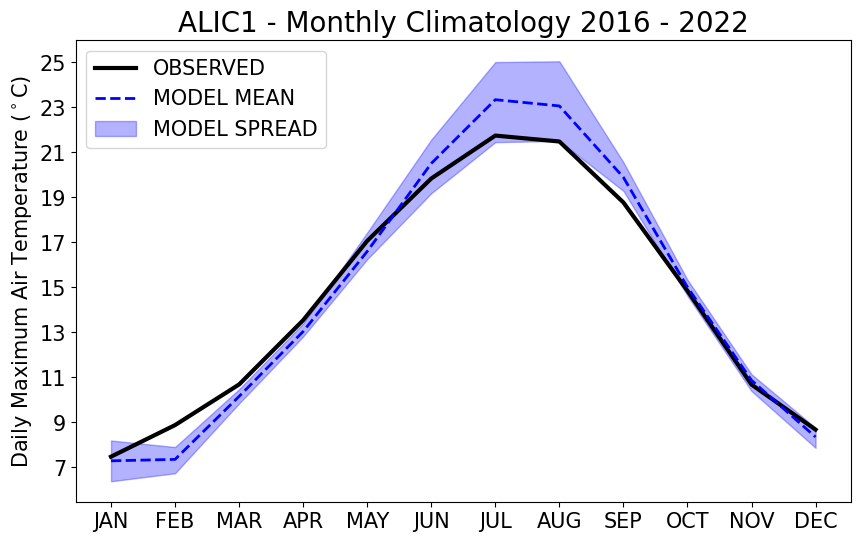

In [58]:
# Plotting monthly climatology of Daily Maximum Air Temperature from COSMOS station ALIC1 and nearest grid point on CHESS-SCAPE averaged over 2016--2022
fig = plt.figure(figsize=(10, 6))
plt.plot(months, df_site.values, color="k", lw=3, label="OBSERVED")
plt.plot(months, df_model_mn.values, color="b", ls="--", lw=2, label="MODEL MEAN")
plt.fill_between(
    months,
    df_model_min.values,
    df_model_max.values,
    color="b",
    alpha=0.3,
    label="MODEL SPREAD",
)
plt.ylabel("Daily Maximum Air Temperature ($^\circ$C)", fontsize=15)
plt.yticks(np.arange(7, 26, 2), fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.title(site_nm + " - Monthly Climatology 2016 - 2022", fontsize=20)
plt.show()

## Resources

[NERC-CEH/object_store_tutorial](https://github.com/NERC-CEH/object_store_tutorial) <br>
This is a GitHub respository with an extensive guide for utilizing object storage. 

[JASMIN Object Storage: Optimizing Performance for Climate Research - JASMIN Conference 2023](https://www.youtube.com/watch?v=xJ8qEXQAri0) <br>
Colleagues from UKCEH present their work on object storage for climate research.


[Zarr-Python](https://zarr.readthedocs.io/en/stable/) <br>
Zarr documentation.



